In [1]:
import numpy as np
import matplotlib.pyplot as plt

class MultilayerPerceptron:
    def __init__(self, input_size, hidden_layer_sizes, output_size, activation_functions_type):
        self.input_size = input_size
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_size = output_size
        self.af_type = activation_functions_type
        self.layers = len(hidden_layer_sizes) + 1 

        self.weights = [np.random.random((input_size, hidden_layer_sizes[0]))]
        self.biases = [np.random.random((1, hidden_layer_sizes[0]))]

        for i in range(1, self.layers-1):
            self.weights.append(np.random.random((hidden_layer_sizes[i - 1], hidden_layer_sizes[i])))
            self.biases.append(np.random.random((1, hidden_layer_sizes[i])))
            
        self.weights.append(np.random.random((hidden_layer_sizes[self.layers-2], output_size)))
        self.biases.append(np.random.random((1, output_size)))
    
    def activation_function(self, x, type='sigmoid'):
        if type == 'sigmoid':
            return 2 / (1 + np.exp(-x)) - 1
        elif type == 'linear':
            return x
        elif type == 'ReLU':
            return np.maximum(0, x)  # ReLU activation function
        elif type == 'tanh':
            return np.tanh(x)
    def activation_function_derivative(self, x, type='sigmoid'):
        if type == 'sigmoid':
            return (1 - self.activation_function(x, type='sigmoid') ** 2) / 2
        elif type == 'linear':
            return 1
        elif type == 'ReLU':
            return np.where(x <= 0, 0, 1)  # Derivative of ReLU
        elif type == 'tanh':
            return 1 - np.tanh(x)**2

    def forward(self, x):
        layer_output = x

        for i in range(self.layers):
            layer_input = layer_output @ self.weights[i] + self.biases[i]
            layer_output = self.activation_function(layer_input, self.af_type[i])

        return layer_output

    def gradient_calculation(self, x, e, Ac):
        layer_outputs = [x]
        layer_inputs = []

        # Forward pass
        for i in range(self.layers):
            layer_input = layer_outputs[i] @ self.weights[i] + self.biases[i]
            layer_inputs.append(layer_input)
            layer_output = self.activation_function(layer_input, self.af_type[i])
            layer_outputs.append(layer_output)

        # Backpropagation
        error = (e @ np.linalg.pinv(Ac) @ np.ones([Ac.shape[1],1]) - .1*layer_output) # *1000#y - layer_outputs[-1]
        delta = error * self.activation_function_derivative(layer_inputs[-1], self.af_type[-1])
        grads = [{'weights': 0, 'bias': 0} for _ in range(self.layers)]

        for i in range(self.layers - 1, -1, -1):
            grads[i]['weights'] = np.mean(np.expand_dims(delta, 1) * np.expand_dims(layer_outputs[i], 2), 0)
            grads[i]['bias'] = np.mean(delta, axis=0, keepdims=True)
            if i > 0:
                # print(delta.shape, self.weights[i].shape)
                error = delta @ self.weights[i].T
                delta = error * self.activation_function_derivative(layer_inputs[i - 1], self.af_type[i - 1])
        return grads

    def train(self, x, e, Ac, update_step_num=10, learning_rate=0.001):
        for i in range(update_step_num):
            grads = self.gradient_calculation(x, e, Ac)

            for j in range(self.layers):
                self.weights[j] += learning_rate * grads[j]['weights']#np.clip(grads[j]['weights'],-1,1)
                self.biases[j] += learning_rate * grads[j]['bias']#np.clip(grads[j]['bias'],-1,1)


In [2]:
# System parameters 
M = 1 #kg
g = 9.81 
L = 1 #m
I = 0.5
J = 0.008
k = 0.3

In [3]:
# Define system ODE: dx/dt = f(x,u)
#x = [q1, q2, q1_dot, q2_dot]
import numpy as np

def sys_ode(x,u):

    dx_1 = x[0][2] 
    dx_2 = x[0][3]
    dx_3 = -M*g*L*np.sin(x[0][0])/I - k/I * (x[0][0]-x[0][1])
    dx_4 = -k/J * (x[0][1]-x[0][0]) + 1/J * u 
    dx = np.array([dx_1, dx_2, dx_3, dx_4[0,0]]).reshape([1,-1])
    
    return dx

In [4]:
class Single_Link_Flexible_Joint:
    def __init__(self, dt = 0.001):
        self.Ac = -20*np.eye(4)
        self.dt = dt
        self.t = np.linspace(0, 10, int((10-0)/dt))
        self.xd = np.array([[.2*np.sin(4*np.pi*self.t/3)], [np.sin(4*np.pi*(self.t)/3)], [np.sin(4*np.pi*self.t/3)], [2*np.cos(4*np.pi*(self.t)/3)]]).T
        self.x = np.array([[.1],[.2],[.3],[.4]]).T
    def step(self, u):
        self.x_dot = sys_ode(self.x, u)
        self.x += self.x_dot * self.dt

In [5]:
mlp = MultilayerPerceptron(input_size = 8, hidden_layer_sizes = [4, 4], output_size = 1, activation_functions_type = ['tanh', 'tanh', 'linear'])
plant = Single_Link_Flexible_Joint()
history = {'x': np.zeros(plant.xd.shape), 'u':[]}
for i in range(len(plant.t)):
    xc = np.concatenate((np.copy(plant.x.T), plant.xd[i].T)).T
    e = np.copy(plant.x) - plant.xd[i]

    u = mlp.forward(xc)
    plant.step(u)
    history['x'][i] = plant.x
    history['u'].append(u[0,0])

    mlp.train(xc, e, plant.Ac, update_step_num = 1, learning_rate=1)

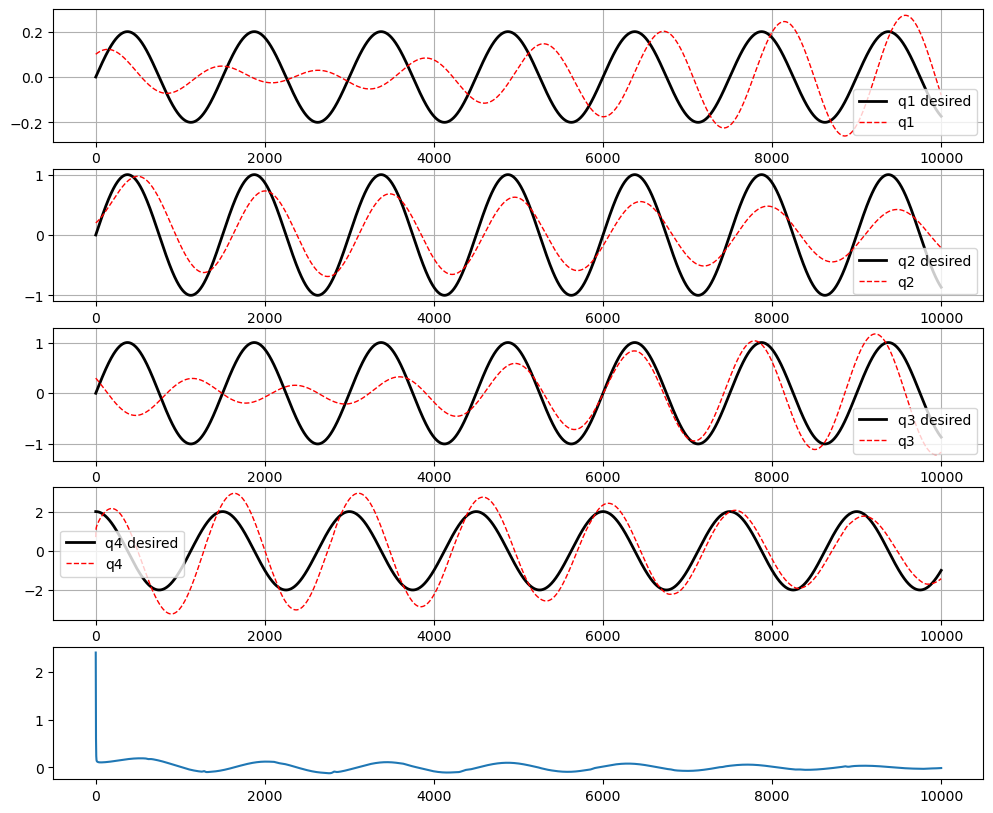

In [6]:
plt.figure(figsize=(12, 10))
for i in range(4):
    plt.subplot(5,1,i+1)
    plt.plot(plant.xd[:,0,i], 'k-', label=f'q{i+1} desired', linewidth = 2)
    plt.plot(history['x'][:,0,i], 'r--', label=f'q{i+1}', linewidth = 1)
    plt.grid('on')
    plt.legend()
plt.subplot(5,1,5)
plt.plot(history['u'])